In [1]:
import pandas as pd

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
gender_sub = pd.read_csv("gender_submission.csv")
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

---
# 1. Big picture

1. We are trying to predict the survivors of the Titanic based on limited information regarding each passenger.
2. Solution will be used to compete with other predictions on Kaggle leaderboard.
3. Current solutions have predictions of up to 100%.
4. This is a supervised offline problem.
5. Performance will be measure by percentage of passengers scored correctly.
6. Performance aligns perfectly with Kaggle goal.
7. Minimum performance is approximately 78% to be placed in top 50% of contestant (desired performance: 79.425% for top 25% of contestants).
8. I can resuse outlier removal tool.
9. Reading about Titanic and survivors may illuminate possible improvements.
10. Manual solution is not desriable here.
11. I have assumed that class and gender will play a large role in the predictions.

---
# 2. Get the data

In [ ]:
gender_sub = pd.read_csv("gender_submission.csv")
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

### train_df

In [9]:
train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Missing values in Age and Cabin categories

In [23]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

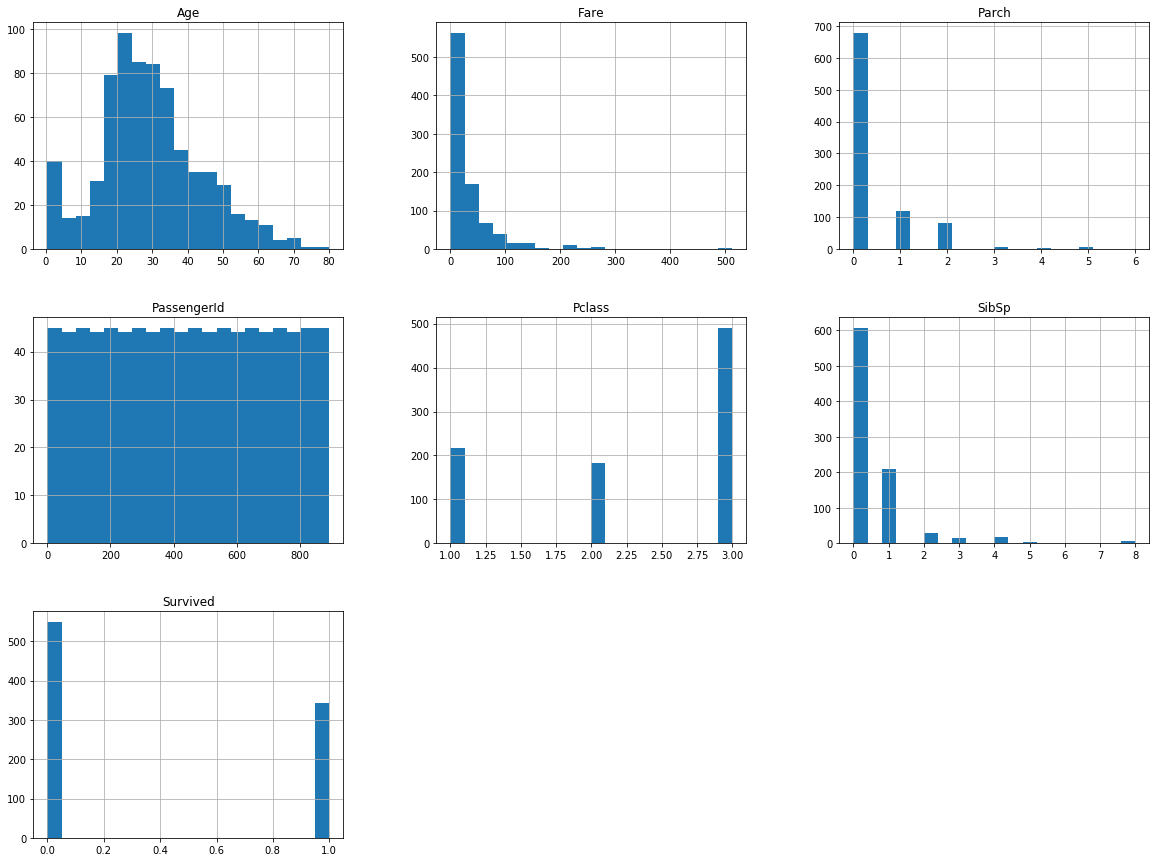

In [27]:
train_df.hist(bins=20,figsize=(20,15));

Notable from histogram 
- Passenger id is evenly spaced
- Age is approximately normally distributed with spike of young children. Slightly right skewed.
- Most fares are similar with few exceptions (notable outliers).
- Most people either had 0 or 1 sibling or spouse (mostly single people and couples?)
- Most people have few parents/children

### test_df

In [8]:
test_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Missing values in Age and Cabin categories.

In [24]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### gender_sub

In [31]:
gender_sub.head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [14]:
gender_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 6.6 KB


---
# 3. Explore the data

In [33]:
passengers = train_df.copy()

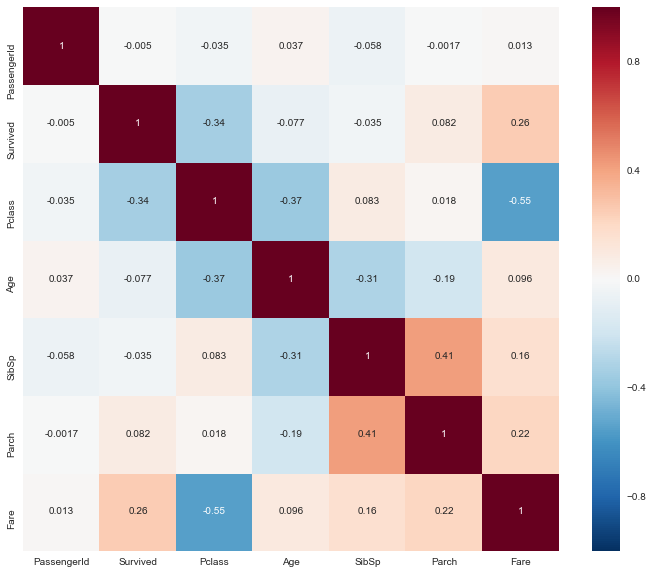

In [70]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix,annot=True)

Notable from corr_matrix:
- Survived has some obvious linear correlation with Fare, Pclass
- Parch and Sibsp are linearly correlated (as we might expect)
- Age has an unexpected relationship with Pclass

Let's look at the linear correlation between Survived and 1) Fare 2) Pclass:

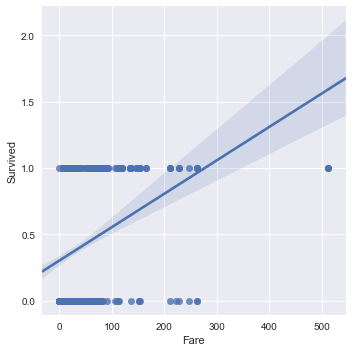

In [62]:
sns.lmplot('Fare','Survived',passengers)

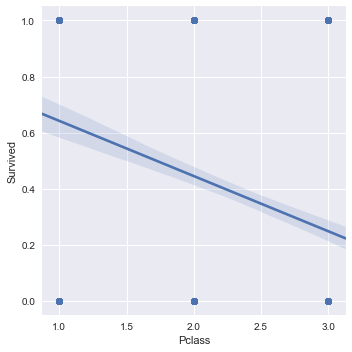

In [63]:
sns.lmplot('Pclass','Survived',passengers)

In [67]:
corr_matrix = passengers.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

It appears that Parch, Fare, Age, and Pclass are most significantly related in a linear fashion

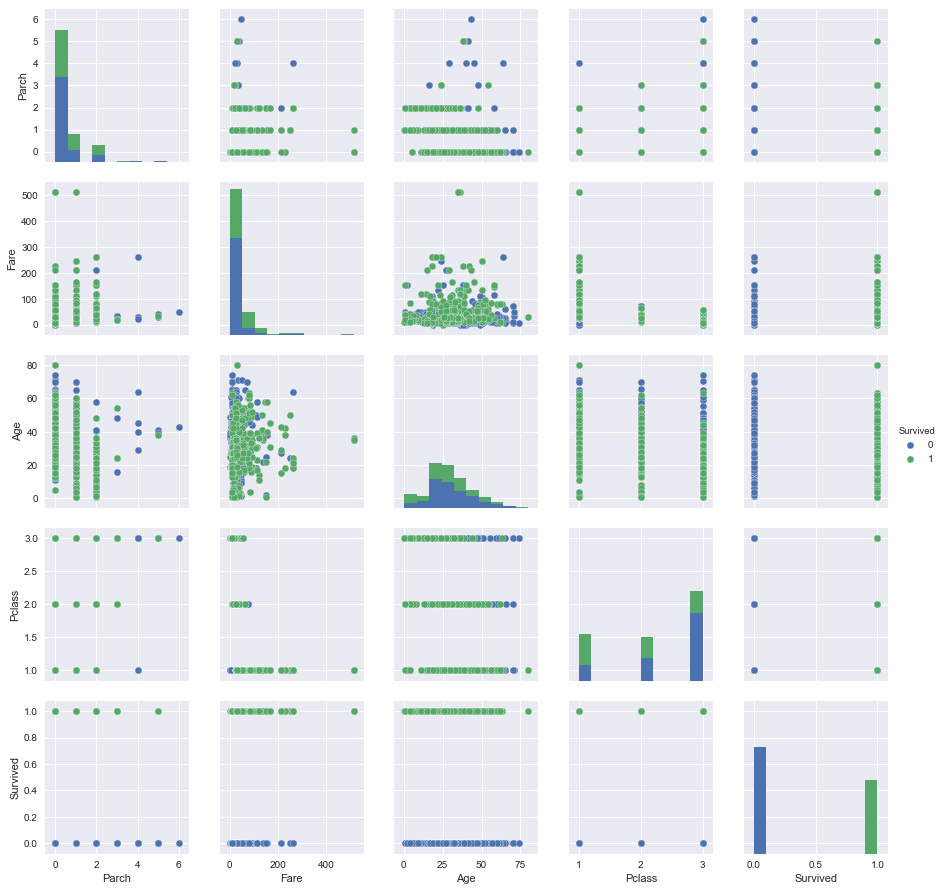

In [82]:
attributes = ['Parch','Fare','Age','Pclass','Survived']
sns.pairplot(passengers[attributes].dropna(),hue='Survived')

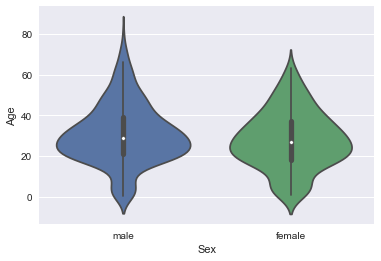

In [44]:
sns.violinplot(x='Sex',y='Age',data=passengers)

# 4. Prepare the data

### Deal with missing data

In [86]:
passengers.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [85]:
len(train_df)

891

#### Cabin 
Category is missing 687/891 values so we will drop that column

In [87]:
passengers.drop('Cabin',axis=1,inplace=True)

#### Age
Age was fairly normally distributed, so we will impute the median Age

In [90]:
from sklearn.preprocessing import Imputer

In [92]:
imputer = Imputer(strategy="median")

In [101]:
imputer.fit(passengers['Age'].values.reshape(-1,1))

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [102]:
imputer.statistics_

array([ 28.])

In [103]:
age_new = imputer.transform(passengers['Age'].values.reshape(-1,1))

In [104]:
age_tr = pd.DataFrame(age_new,columns=['Age'])

In [201]:
passengers['Age']=age_tr

#### Embarked
Embarked is missing 2 values. We will replace these with the most common embarked location.

In [202]:
passengers['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [203]:
passengers['Embarked'].fillna('S',inplace=True)

In [107]:
#imputer = Imputer(strategy="most_frequent")
#imputer.fit(passengers['Embarked'].values.reshape(-1,1))
#imputer.statistics_

### Handling Categorical attributes

In [204]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


The following 4 attributes are text or categorical:
- Name
- Sex
- Ticket
- Embarked

In [205]:
passengers_non_numeric = passengers[['Name','Sex','Ticket','Embarked']]
passengers_non_numeric.head(2)

,Name,Sex,Ticket,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C


In [206]:
passengers_non_numeric.nunique()

Name        891
Sex           2
Ticket      681
Embarked      3
dtype: int64

It appears that the name and tickets are mostly unique. We will encode Sex and Embarked.

In [207]:
from sklearn.preprocessing import LabelBinarizer

In [208]:
encoder = LabelBinarizer()

In [209]:
cat_features = ['Sex','Embarked']

passengers_cat = passengers[cat_features]

In [210]:
passengers_sex_encoded = encoder.fit_transform(passengers['Sex'])
passengers_embarked_encoded = encoder.fit_transform(passengers['Embarked'])

In [211]:
sex_encoded_df = pd.DataFrame(passengers_sex_encoded,columns=['Sex_Encoded'])

embarked_encoded_df = pd.DataFrame(passengers_embarked_encoded,columns=passengers['Embarked'].unique())

In [212]:
passengers_with_sex = passengers.merge(sex_encoded_df,left_index=True,right_index=True)

passengers_encoded = passengers_with_sex.merge(embarked_encoded_df,left_index=True,right_index=True)

In [213]:
passengers_encoded.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Encoded,S,C,Q
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,0,1


### Feature scaling

In [214]:
#from sklearn.preprocessing import StandardScaler

In [215]:
#scaler = StandardScaler()

In [216]:
#nurical_features = ['Age','Fare']

In [217]:
#scaler.fit_transform(passengers_encoded[numerical_features])

### Transform test (replace with pipeline)

In [328]:
test=test_df.copy()

#Missing Data
test.drop('Cabin',axis=1,inplace=True)
test['Age'].fillna(28,inplace=True)
test['Embarked'].fillna('S',inplace=True)
test['Fare'].fillna(14.4542,inplace=True)

#Encoding
encoder = LabelBinarizer()

cat_features = ['Sex','Embarked']
test_cat = test[cat_features]

test_sex_encoded = encoder.fit_transform(test['Sex'])
sex_encoded_df = pd.DataFrame(test_sex_encoded,columns=['Sex_Encoded'])
test_with_sex = test.merge(sex_encoded_df,left_index=True,right_index=True)

test_embarked_encoded = encoder.fit_transform(test['Embarked'])
embarked_encoded_df = pd.DataFrame(test_embarked_encoded,columns=test['Embarked'].unique())


test_encoded = test_with_sex.merge(embarked_encoded_df,left_index=True,right_index=True)

#Feature selection:
features = ['Pclass', 'Age', 'SibSp','Parch', 'Fare', 'Sex_Encoded', 'C', 'Q']
test_prepared = test_encoded[features]

In [329]:
test_prepared[test_prepared.isnull().any(axis=1)]

,Pclass,Age,SibSp,Parch,Fare,Sex_Encoded,C,Q


In [314]:
test_prepared.head(2)

,Pclass,Age,SibSp,Parch,Fare,Sex_Encoded,C,Q
0,3,34.5,0,0,7.8292,1,0,0
1,3,47.0,1,0,7.0000,0,1,0


### Pipeline

In [310]:
"""
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
"""

In [ ]:
"""
num_attributes = 
cat_attributes = ['']
"""

In [ ]:
"""
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
"""

In [ ]:
"""
num_pipeline = Pipeline([
    ('imputer',Imputer(strategy='median')), #Impute median age for missing values
])
"""

In [ ]:
"""
def fill_embarked_with_S(df:
    passengers['Embarked'].fillna('S',inplace=True)
"""

In [219]:
"""
cat_pipeline = ([
    ()
])
"""

In [ ]:
"""
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline",num_pipeline),
    ("cat_pipeline",cat_pipeline),
])
"""

In [ ]:
# Note drop cabin
#passengers.drop('Cabin',axis=1,inplace=True)

---
# 5. Short-list promising models

In [220]:
passengers_encoded.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Sex_Encoded', 'S', 'C', 'Q'],
      dtype='object')

In [364]:
features = ['Pclass', 'Age', 'SibSp','Parch', 'Fare', 'Sex_Encoded', 'C', 'Q']

In [523]:
passengers_prepared = passengers_encoded[features]
passengers_labels = passengers_encoded['Survived']

#### Classifier overview

In [242]:
from sklearn.model_selection import cross_val_score

In [267]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [269]:
#Ensemble
rfc = RandomForestClassifier()
ada_boost = AdaBoostClassifier()
bag = BaggingClassifier()
extra_trees = ExtraTreesClassifier()
grad_boost = GradientBoostingClassifier()

#SVM
svc = SVC()

#Neigbors
knn = KNeighborsClassifier()

In [270]:
classifiers = [rfc,ada_boost,bag,extra_trees,grad_boost,svc,knn]

In [284]:
highest_score=0
best_classifier=""
best_classifier_training_score=0

for clf in classifiers:
    clf.fit(passengers_prepared,passengers_labels)

    pred = clf.predict(passengers_prepared)

    scores = cross_val_score(clf, passengers_prepared, passengers_labels, cv=10)
    
    training_score=clf.score(passengers_prepared,passengers_labels)
    cv_score_mean = scores.mean()
    
    if cv_score_mean>highest_score:
        highest_score=cv_score_mean
        best_classifier=clf
        best_classifier_training_score=training_score

    print("\n{}:\n\n\tTraining Score: {} \n\tCV Scores: {}".format(clf,training_score,cv_score_mean))
    
print('\n\n----------------\nBest estimator:{}\n\n\tTraining Score: {} \n\tCV Scores: {}'.format(best_classifier,highest_score,best_classifier_training_score))


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False):

	Training Score: 0.9674523007856342 
	CV Scores: 0.8048269208943367

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None):

	Training Score: 0.8338945005611672 
	CV Scores: 0.8115687776642833

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False):

	Training Score: 0.9640852974186308 
	CV Scores: 0.8115821132675066

Extr

Gradient Boosting Classifier is our best scoring with default values

In [286]:
best_classifier

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

---
# 6. Fine-tune the system

In [287]:
from sklearn.model_selection import GridSearchCV

#### Round 1

In [289]:
#8 total features
len(passengers_prepared.columns)

8

In [291]:
param_grid = [
    {'max_depth':[1,3,10],'max_features':[2,4,6,8],'min_samples_split':[2,4]}
]

In [299]:
grid_search = GridSearchCV(grad_boost,param_grid,cv=5,verbose=3)

In [301]:
grid_search.fit(passengers_prepared,passengers_labels)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] max_depth=1, max_features=2, min_samples_split=2 ................
[CV]  max_depth=1, max_features=2, min_samples_split=2, score=0.7932960893854749, total=   0.0s
[CV] max_depth=1, max_features=2, min_samples_split=2 ................
[CV]  max_depth=1, max_features=2, min_samples_split=2, score=0.8212290502793296, total=   0.0s
[CV] max_depth=1, max_features=2, min_samples_split=2 ................
[CV]  max_depth=1, max_features=2, min_samples_split=2, score=0.797752808988764, total=   0.0s
[CV] max_depth=1, max_features=2, min_samples_split=2 ................
[CV]  max_depth=1, max_features=2, min_samples_split=2, score=0.7696629213483146, total=   0.0s
[CV] max_depth=1, max_features=2, min_samples_split=2 ................
[CV]  max_depth=1, max_features=2, min_samples_split=2, score=0.8022598870056498, total=   0.0s
[CV] max_depth=1, max_features=2, min_samples_split=4 ................
[CV]  max_depth=1, max_features=2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=1, max_features=2, min_samples_split=4 ................
[CV]  max_depth=1, max_features=2, min_samples_split=4, score=0.7921348314606742, total=   0.0s
[CV] max_depth=1, max_features=2, min_samples_split=4 ................
[CV]  max_depth=1, max_features=2, min_samples_split=4, score=0.7921348314606742, total=   0.0s
[CV] max_depth=1, max_features=2, min_samples_split=4 ................
[CV]  max_depth=1, max_features=2, min_samples_split=4, score=0.7966101694915254, total=   0.0s
[CV] max_depth=1, max_features=4, min_samples_split=2 ................
[CV]  max_depth=1, max_features=4, min_samples_split=2, score=0.7988826815642458, total=   0.0s
[CV] max_depth=1, max_features=4, min_samples_split=2 ................
[CV]  max_depth=1, max_features=4, min_samples_split=2, score=0.8268156424581006, total=   0.0s
[CV] max_depth=1, max_features=4, min_samples_split=2 ................
[CV]  max_depth=1, max_features=4, min_samples_split=2, score=0.8033707865168539, total=   0.

[CV]  max_depth=3, max_features=4, min_samples_split=4, score=0.8212290502793296, total=   0.0s
[CV] max_depth=3, max_features=4, min_samples_split=4 ................
[CV]  max_depth=3, max_features=4, min_samples_split=4, score=0.8314606741573034, total=   0.0s
[CV] max_depth=3, max_features=4, min_samples_split=4 ................
[CV]  max_depth=3, max_features=4, min_samples_split=4, score=0.8033707865168539, total=   0.0s
[CV] max_depth=3, max_features=4, min_samples_split=4 ................
[CV]  max_depth=3, max_features=4, min_samples_split=4, score=0.8531073446327684, total=   0.0s
[CV] max_depth=3, max_features=6, min_samples_split=2 ................
[CV]  max_depth=3, max_features=6, min_samples_split=2, score=0.8044692737430168, total=   0.0s
[CV] max_depth=3, max_features=6, min_samples_split=2 ................
[CV]  max_depth=3, max_features=6, min_samples_split=2, score=0.8100558659217877, total=   0.0s
[CV] max_depth=3, max_features=6, min_samples_split=2 ...............

[CV]  max_depth=10, max_features=6, min_samples_split=4, score=0.7821229050279329, total=   0.2s
[CV] max_depth=10, max_features=6, min_samples_split=4 ...............
[CV]  max_depth=10, max_features=6, min_samples_split=4, score=0.8268156424581006, total=   0.2s
[CV] max_depth=10, max_features=6, min_samples_split=4 ...............
[CV]  max_depth=10, max_features=6, min_samples_split=4, score=0.8146067415730337, total=   0.2s
[CV] max_depth=10, max_features=6, min_samples_split=4 ...............
[CV]  max_depth=10, max_features=6, min_samples_split=4, score=0.7865168539325843, total=   0.2s
[CV] max_depth=10, max_features=6, min_samples_split=4 ...............
[CV]  max_depth=10, max_features=6, min_samples_split=4, score=0.8192090395480226, total=   0.2s
[CV] max_depth=10, max_features=8, min_samples_split=2 ...............
[CV]  max_depth=10, max_features=8, min_samples_split=2, score=0.7653631284916201, total=   0.3s
[CV] max_depth=10, max_features=8, min_samples_split=2 ........

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   18.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [1, 3, 10], 'max_features': [2, 4, 6, 8], 'min_samples_split': [2, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [302]:
#from sklearn.model_selection import RandomizedSearchCV
#rand_search = RandomizedSearchCV(grad_boost,param_grid,cv=5)
#rand_search.fit(passengers_prepared,passengers_labels)

In [303]:
grid_search.best_params_

{'max_depth': 3, 'max_features': 8, 'min_samples_split': 4}

In [304]:
grid_search.best_score_

0.83052749719416386

In [306]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([ 0.05750185,  0.32313836,  0.04165673,  0.01425025,  0.3984754 ,
        0.13179281,  0.00427073,  0.02891387])

In [307]:
sorted(zip(feature_importances,passengers_prepared.columns),reverse=True)

[(0.39847540381000562, 'Fare'),
 (0.32313836001089585, 'Age'),
 (0.13179280605732163, 'Sex_Encoded'),
 (0.057501849179834794, 'Pclass'),
 (0.041656729261218148, 'SibSp'),
 (0.028913870228815006, 'Q'),
 (0.014250250476022921, 'Parch'),
 (0.0042707309758859054, 'C')]

In [345]:
from sklearn.externals import joblib

In [346]:
joblib.dump(grid_search.best_estimator_, "Gradient Boosting 1.pkl")

['Gradient Boosting 1.pkl']

Our current model sees fare, age, and sex as the most important attributes.

#### Round 2 - remove less related features and min_samples_split

In [366]:
features

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_Encoded', 'C', 'Q']

In [365]:
limited_features = features.copy()

for feature in ['C','Q','Parch']:
    limited_features.remove(feature)
    
limited_features

['Pclass', 'Age', 'SibSp', 'Fare', 'Sex_Encoded']

In [382]:
passengers_prepared = passengers_encoded[limited_features]

In [369]:
#Old model param_grid
grid_search.param_grid

[{'max_depth': [1, 3, 10],
  'max_features': [2, 4, 6, 8],
  'min_samples_split': [2, 4]}]

In [368]:
grid_search.best_params_

{'max_depth': 3, 'max_features': 8, 'min_samples_split': 4}

In [383]:
param_grid = [
    {'max_depth':[3],'min_samples_split':[4,10,20,30,40,50,60,100]}
]

In [384]:
grid_search = GridSearchCV(grad_boost,param_grid,cv=5,verbose=1)
grid_search.fit(passengers_prepared,passengers_labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [3], 'min_samples_split': [4, 10, 20, 30, 40, 50, 60, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [385]:
grid_search.best_params_

{'max_depth': 3, 'min_samples_split': 20}

In [386]:
grid_search.best_score_

0.8271604938271605

Lower score, but I think we may be overfitting less.

*min_samples_split = 20*

#### Round 3 - Max depth

In [395]:
param_grid = [
    {'max_depth':[1,2,3,4,5,6],'min_samples_split':[20]}
]

In [396]:
grid_search = GridSearchCV(grad_boost,param_grid,cv=5,verbose=1)
grid_search.fit(passengers_prepared,passengers_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6], 'min_samples_split': [20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [397]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_split': 20}

In [399]:
grid_search.best_score_

0.83389450056116721

*max_depth = 5*

#### Round 4 - Learning Rate

In [405]:
param_grid = [
    {'max_depth':[5],'min_samples_split':[20],'learning_rate':[0.2,0.1,0.01,0.001]}
]

grid_search = GridSearchCV(grad_boost,param_grid,cv=5,verbose=0)
grid_search.fit(passengers_prepared,passengers_labels)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 20}

*learning_rate = 0.1 * (default)

#### Round 5 - min_samples_leaf

In [408]:
param_grid = [
    {'max_depth':[5],'min_samples_split':[20],'min_samples_leaf':[1,20,30,40,50,60,70,80,100]}
]

grid_search = GridSearchCV(grad_boost,param_grid,cv=5,verbose=0)
grid_search.fit(passengers_prepared,passengers_labels)

grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 20}

In [419]:
grid_search.best_score_

0.84175084175084181

*min_samples_leaf = 50*

#### Round 6 - All parameters exploration

In [420]:
param_grid = [
    {'max_depth':[3,4,5],'min_samples_split':[15,20,25],'min_samples_leaf':[40,50,60]}
]

grid_search = GridSearchCV(grad_boost,param_grid,cv=5,verbose=0)
grid_search.fit(passengers_prepared,passengers_labels)

grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 15}

In [418]:
grid_search.best_score_

0.84175084175084181

#### Save final model

In [443]:
final_grad_boost_model = grid_search.best_estimator_

## Alternative method - XGB

In [430]:
import xgboost as xgb

In [432]:
xg = xgb.XGBClassifier()

In [435]:
xg.fit(passengers_prepared,passengers_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [437]:
xg.score(passengers_prepared,passengers_labels)

0.87317620650953987

In [439]:
pred = xg.predict(test_prepared[limited_features])

#### Round 1

In [482]:
max_depth = [2,3,4,5]
learning_rate = [0.3,0.2,0.1,0.01]

In [483]:
param_grid=[{'max_depth':max_depth,'learning_rate':learning_rate}]

grid_search = GridSearchCV(xg,param_grid,cv=10,verbose=0)
grid_search.fit(passengers_prepared,passengers_labels)

grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 2}

In [457]:
grid_search.best_score_

0.83838383838383834

In [464]:
grid_search.best_estimator_.score(passengers_prepared,passengers_labels)

0.88215488215488214

In [475]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):

    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

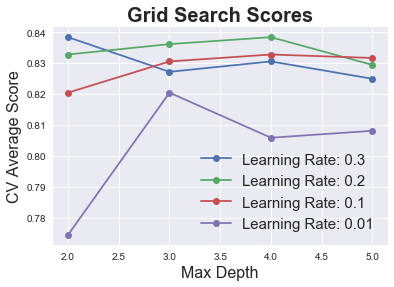

In [484]:
# Calling Method 
plot_grid_search(grid_search.cv_results_, max_depth, learning_rate, 'Max Depth', 'Learning Rate')

In [485]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 2}

#### Round 2

In [488]:
xg.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>

In [498]:
xg.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [526]:
max_depth = [2,3,4,5]
learning_rate = [0.3,0.2,0.1,0.01]
base_score = [0.8,0.9,.95,.99]#[0.1,0.2,0.4,0.5,0.6,0.8,0.9]

param_grid=[{'max_depth':max_depth,'learning_rate':learning_rate,'base_score':base_score}]

grid_search = GridSearchCV(xg,param_grid,cv=10,verbose=0)
grid_search.fit(passengers_prepared,passengers_labels)

grid_search.best_params_

{'base_score': 0.99, 'learning_rate': 0.1, 'max_depth': 5}

In [527]:
grid_search.best_score_

0.83838383838383834

In [524]:
max_depth = [2]
learning_rate = [0.3]
base_score = [0.9]#[0.1,0.2,0.4,0.5,0.6,0.8,0.9]
n_estimators = [100]#,200,300]


param_grid=[{'max_depth':max_depth,'learning_rate':learning_rate,'base_score':base_score,'n_estimators':n_estimators}]

grid_search = GridSearchCV(xg,param_grid,cv=10,verbose=0)
grid_search.fit(passengers_prepared,passengers_labels)

grid_search.best_params_

{'base_score': 0.9, 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}

In [525]:
grid_search.best_score_

0.83164983164983164

In [540]:
parameters = grid_search.best_params_

#### Save final model

In [528]:
final_xg_model = grid_search.best_estimator_

#### XGBoost training

In [536]:
from sklearn.model_selection import train_test_split

In [538]:
X_train, X_test, y_train, y_test = train_test_split(passengers_prepared.values,passengers_labels, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

watchlist = [(dtrain,'dtrain'),(dtest,'dtest')]

In [543]:
xgbr = xgb.train(params=parameters,
                 dtrain=dtrain,
                 num_boost_round=200,
                 evals=watchlist,
                 early_stopping_rounds=40,
                 maximize=False,
                verbose_eval=10)

[0]	dtrain-rmse:0.71916	dtest-rmse:0.700428
Multiple eval metrics have been passed: 'dtest-rmse' will be used for early stopping.

Will train until dtest-rmse hasn't improved in 40 rounds.
[10]	dtrain-rmse:0.392591	dtest-rmse:0.417726
[20]	dtrain-rmse:0.313612	dtest-rmse:0.372436
[30]	dtrain-rmse:0.291004	dtest-rmse:0.367908
[40]	dtrain-rmse:0.280168	dtest-rmse:0.365738
[50]	dtrain-rmse:0.270538	dtest-rmse:0.365322
[60]	dtrain-rmse:0.259297	dtest-rmse:0.364712
[70]	dtrain-rmse:0.252602	dtest-rmse:0.365676
[80]	dtrain-rmse:0.2447	dtest-rmse:0.367416
[90]	dtrain-rmse:0.237329	dtest-rmse:0.368228
Stopping. Best iteration:
[54]	dtrain-rmse:0.266011	dtest-rmse:0.363003



In [544]:
xgbr.best_score

0.363003

In [547]:
dfinal = xgb.DMatrix(test_prepared.values)

In [583]:
pred = xgbr.predict(dfinal)

In [588]:
pred=np.round(pred).astype(int)

---
# 7. Present your solution

We used Gradient boosted trees on all of the features which were applicable.

We imputed median values for missing numeric values and the most common value for port of departure.

We used a limited grid search to hyper tune parameters.

To improve the model, the further fine-typing could be preformed or xgboost could be experimented with.

For personal improvement, I need to work on the pipeline and learn how to transform the test data with the pipeline.

# 8 Launch

In [549]:
final_model = final_xg_model #final_grad_boost_model

In [552]:
pred = final_model.predict(test_prepared)

In [589]:
pred_df = pd.DataFrame(pred,columns=['Survived'])
ids_df = pd.DataFrame(test['PassengerId'],columns=['PassengerId'])

In [590]:
sub_df = ids_df.merge(pred_df,left_index=True,right_index=True)

In [591]:
sub_df.to_csv('XGBoost with training.csv',index=False)